# Group Analysis - FOOOFed EEG Analysis

In [1]:
%matplotlib inline

from os import listdir
from os.path import join as pjoin

import numpy as np
import matplotlib.pyplot as plt

from fooof import FOOOFGroup

#
from utils import *

In [2]:
# Set path to load results from
res_path = '/Users/tom/Documents/Research/1-Projects/fooof/2-Data/Results/'

In [3]:
# Settings
#avg_func = np.mean
avg_func = np.median

In [4]:
# Load alpha peaks
alpha_freqs = np.load(pjoin(res_path, 'Group', 'alpha_freqs_group.npy'))
for ind, subj_alph in enumerate(alpha_freqs):
    print(ind, '\t {:5.2f}'.format(subj_alph))

0 	 11.17
1 	 12.49
2 	 10.10
3 	 10.74
4 	 10.93
5 	 10.19
6 	 11.31
7 	 10.58
8 	  9.24
9 	 10.32
10 	 10.31


In [5]:
# Load dropped trials 
dropped_trials = np.load(pjoin(res_path, 'Group', 'dropped_trials.npy'))

# Check dropped trials for each subject
for ind, subj_dropped in enumerate(dropped_trials):
    temp = subj_dropped[np.nonzero(subj_dropped)]
    print(ind, '\t', len(temp))

0 	 33
1 	 29
2 	 36
3 	 98
4 	 39
5 	 23
6 	 58
7 	 87
8 	 54
9 	 9
10 	 26


In [6]:
# Load data
canonical_group = np.load(pjoin(res_path, 'Group', 'canonical_group.npy'))
fooofed_group = np.load(pjoin(res_path, 'Group', 'fooofed_group.npy'))

In [7]:
# #Test: drop subjects
# canonical_group[2, :, :] = 0
# fooofed_group[2, :, :] = 0
# canonical_group[7, :, :] = 0
# fooofed_group[7, :, :] = 0

In [8]:
# Average across subjects
canonical_group_avg = avg_func(canonical_group, 0)
fooofed_group_avg = avg_func(fooofed_group, 0)

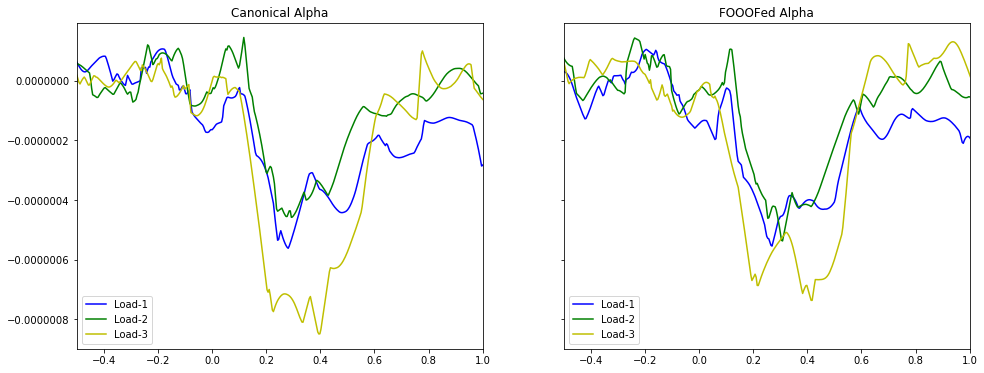

In [9]:
# 
plot_alpha_response_compare(canonical_group_avg, fooofed_group_avg)

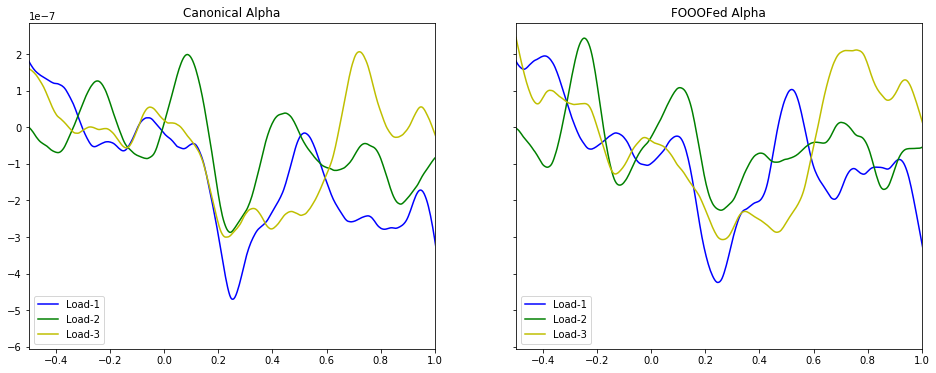

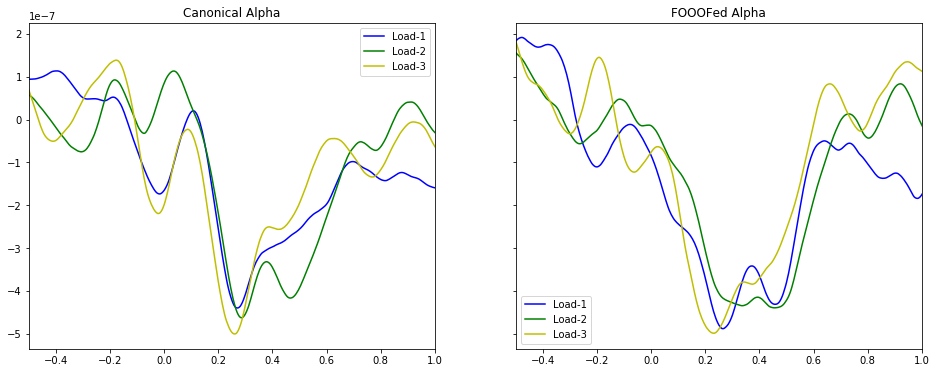

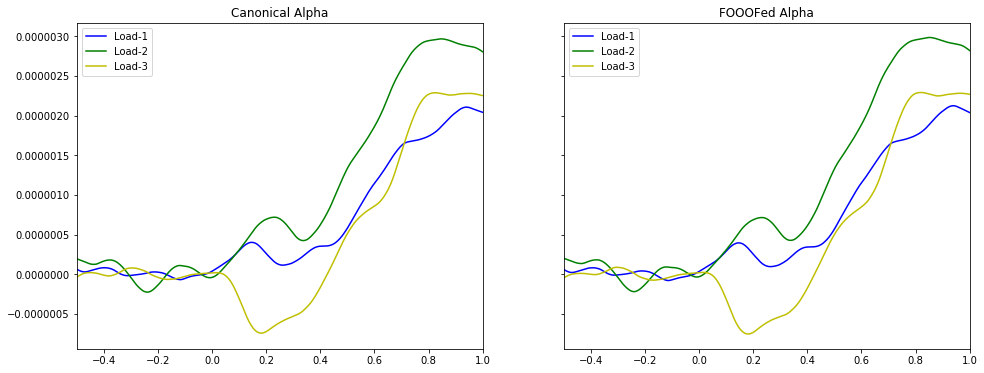

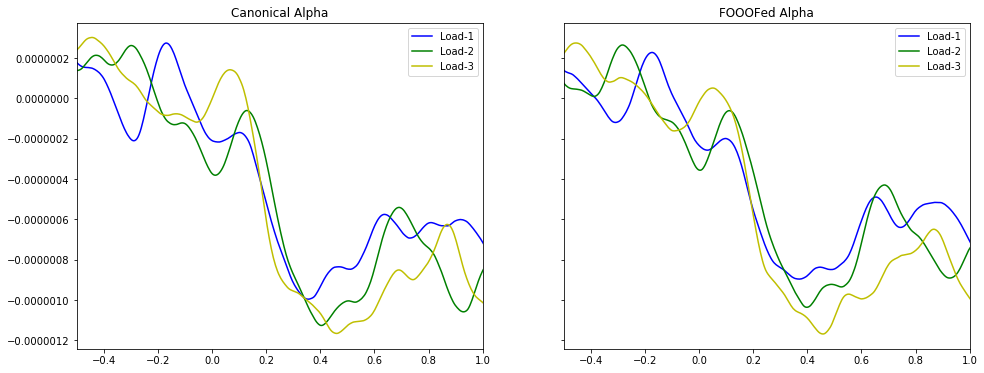

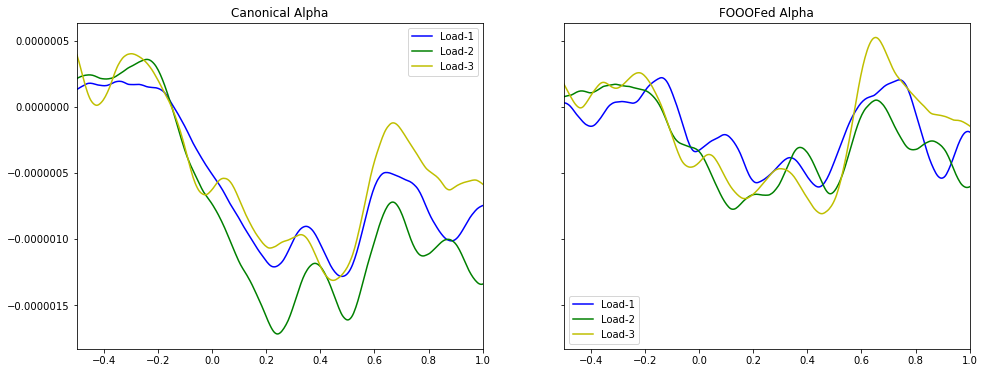

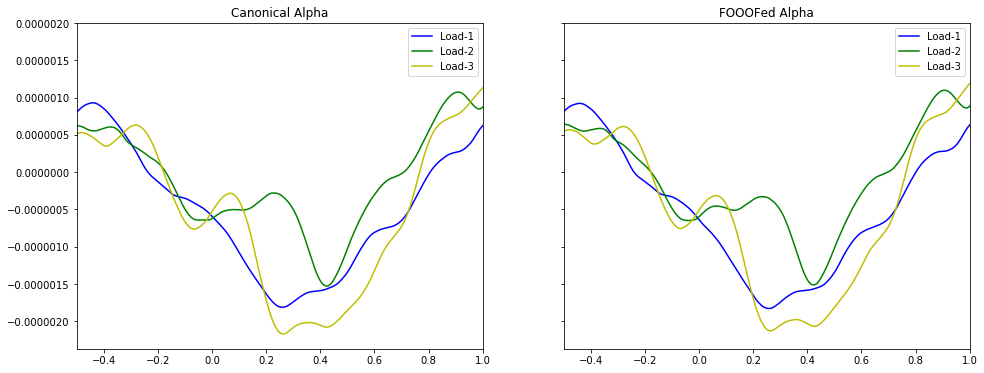

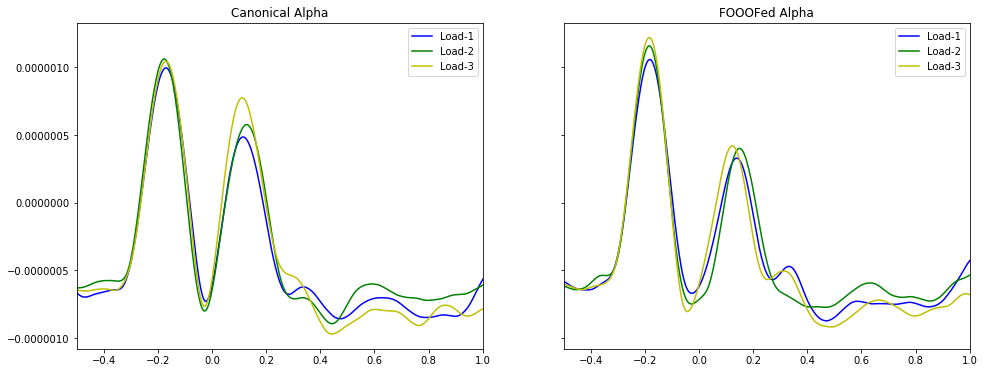

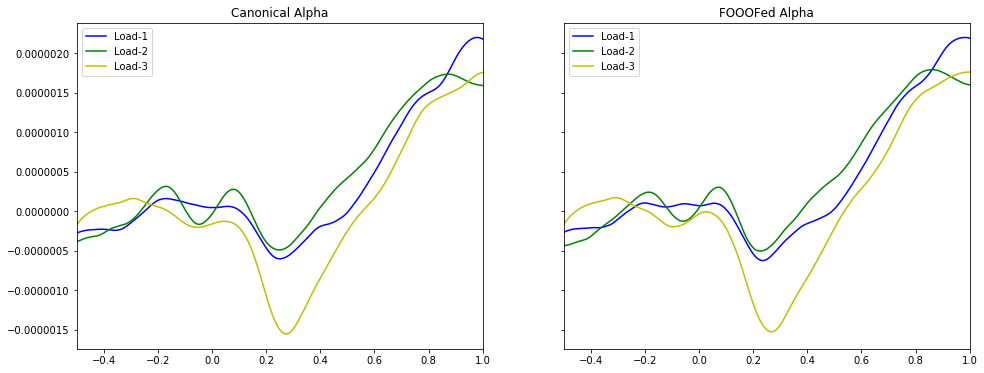

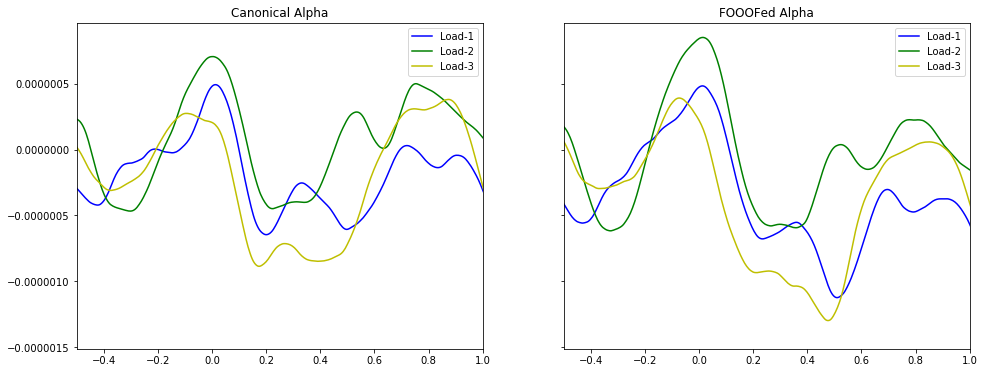

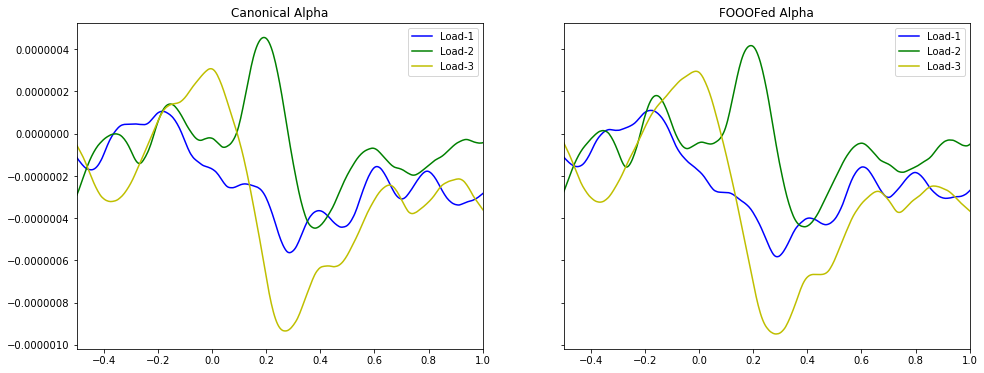

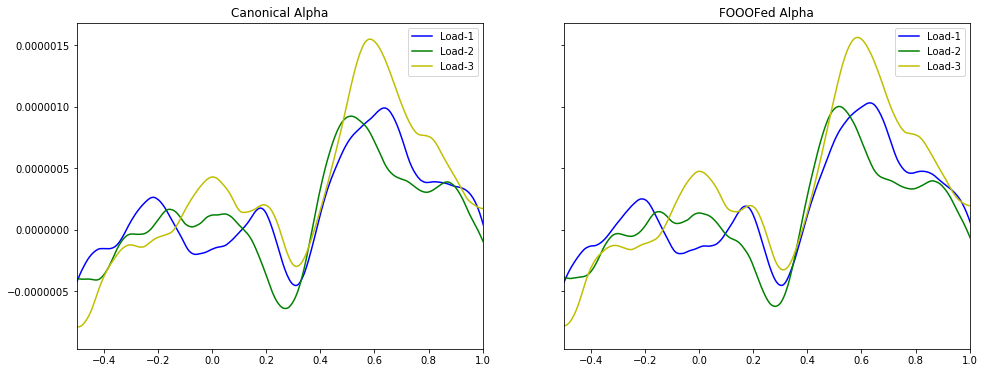

In [10]:
# Plot each individual subject
for alpha_subj, fooof_subj in zip(canonical_group, fooofed_group):
    plot_alpha_response_compare(alpha_subj, fooof_subj)

In [11]:
# Grab the time that represent the late time period: 0.8 - 1.0
times = np.arange(-0.5, 1.2, 1/256)
late_times = np.array(times >= 0.8) & np.array(times <= 1.0)

In [12]:
# Extract late time period, and average across it
#canonical_group_late = np.mean(canonical_group[:, :, late_times], 2)
#fooofed_group_late = np.mean(fooofed_group[:, :, late_times], 2)

canonical_group_late = np.median(canonical_group[:, :, late_times], 2)
fooofed_group_late = np.median(fooofed_group[:, :, late_times], 2)

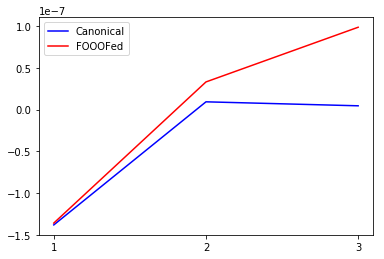

In [13]:
# Plot 
plt.figure()
plt.plot(avg_func(canonical_group_late, 0), 'b', label='Canonical')
plt.plot(avg_func(fooofed_group_late, 0), 'r', label='FOOOFed')
plt.xticks([0, 1, 2], [1, 2, 3]);
plt.legend();

<Container object of 3 artists>

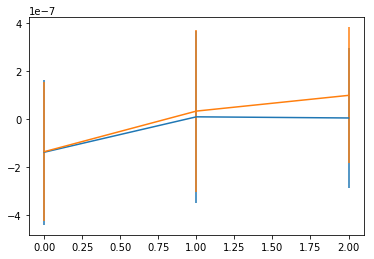

In [14]:
from scipy import stats

plt.figure()
plt.errorbar([0, 1, 2], np.median(canonical_group_late, 0), stats.sem(canonical_group_late))
plt.errorbar([0, 1, 2], np.median(fooofed_group_late, 0), stats.sem(fooofed_group_late))

In [15]:
#canonical_group_late

In [16]:
# print(stats.f_oneway(*canonical_group_late))
# print(stats.f_oneway(*fooofed_group_late))

In [17]:
# dat = np.array([[1, 1, 1, 1, 1], [2, 2, 2, 2, 2], [3, 3, 3, 3, 3]])
# stats.f_oneway(*dat)

In [18]:
#import statsmodels.api as sm
#table = sm.stats.anova_lm(moore_lm, typ=2)
#stats.f_oneway(canonical_group_late)

## FOOOF

In [19]:
#
files = listdir(pjoin(res_path, 'FOOOF'))

In [20]:
files = files[2:-3]

In [21]:
fg.load(files[0], pjoin(res_path, 'FOOOF'))

NameError: name 'fg' is not defined

In [ ]:
fg.group_results

In [ ]:
fg = FOOOFGroup()
for file in files:
    fg.load(file, pjoin(res_path, 'FOOOF'))
    #fg.plot()

## Other FOOOFing

In [22]:
from fooof.analysis import get_band_peak_group

In [23]:
# Load the FOOOF analyses of the average
load_1, load_2, load_3 = FOOOFGroup(), FOOOFGroup(), FOOOFGroup()
load_1.load('Group_Load1', pjoin(res_path, 'FOOOF'))
load_2.load('Group_Load2', pjoin(res_path, 'FOOOF'))
load_3.load('Group_Load3', pjoin(res_path, 'FOOOF'))

In [49]:
all_slopes = np.zeros(shape=[11, 3])
all_alphas = np.zeros(shape=[11, 3])
for ind, fg in enumerate([load_1, load_2, load_3]):
    all_slopes[:, ind] = fg.get_all_data('background_params', 'slope').T
    all_alphas[:, ind] = get_band_peak_group(fg.get_all_data('peak_params'), [7, 14], len(fg))[:, 2]

In [50]:
all_slopes

array([[1.3114357 , 1.22040681, 1.29131432],
       [0.59337903, 0.59818814, 0.67931634],
       [1.00385333, 0.97357638, 1.01442721],
       [1.29462576, 1.19955586, 1.34481886],
       [1.65600503, 1.59811601, 1.81428587],
       [1.17908823, 1.38930759, 1.16929437],
       [1.44538101, 1.35579363, 1.48920721],
       [1.21622118, 1.17815352, 1.29848425],
       [1.7453934 , 1.81408683, 1.78407593],
       [1.74920199, 1.67624894, 1.82382986],
       [1.80364725, 1.98855128, 1.92178351]])

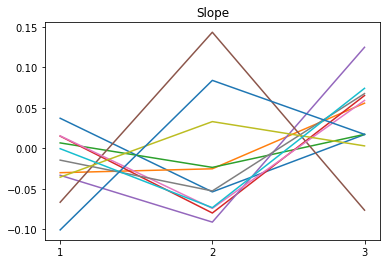

In [51]:
plt.figure()
for dat in all_slopes:
    plt.plot(dat - np.mean(dat))
plt.xticks([0, 1, 2], [1, 2, 3]);
plt.title('Slope');

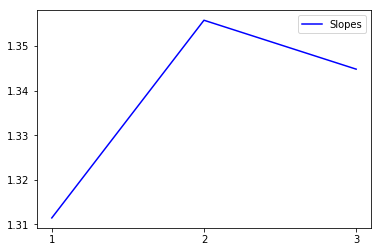

In [52]:
# Plot 
plt.figure()
plt.plot(avg_func(all_slopes, 0), 'b', label='Slopes')
#plt.plot(avg_func(all_alphas, 0), 'b', label='Alpha')
plt.xticks([0, 1, 2], [1, 2, 3]);
plt.legend();

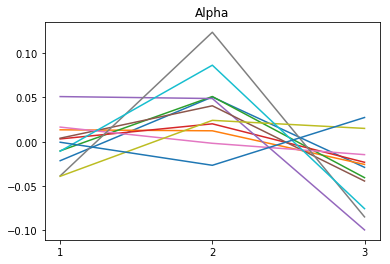

In [48]:
plt.figure()
for dat in all_alphas:
    #plt.plot(dat)
    plt.plot(dat - np.mean(dat))
plt.xticks([0, 1, 2], [1, 2, 3]);
plt.title('Alpha');

In [ ]:
plt.boxplot([load_1.get_all_data('background_params', 'slope'), 
            load_2.get_all_data('background_params', 'slope'),
            load_3.get_all_data('background_params', 'slope')]);